# Clean Tweets Analysis

Tweets are scraped using the `baseline-user-ids.json` input (a list of User IDs) in `twitter_scraper.scrape`. To collect Tweets incrementally, the `scrape` module makes use of `since_id` and `max_id` paramaters issued by [Twitter API](https://developer.twitter.com/en/docs/twitter-api/v1/tweets/timelines/api-reference/get-statuses-user_timeline).

All Tweets are filter by a given date interval, that is currently all Tweets from June 1st, 2022 (2022-06-01).


Tweets data schema:

Column                    | Description                                                           | Data Type
------------------------- | --------------------------------------------------------------------- | -------
id                        | Numeric Tweet identifier                                              | int64
created_at                | Date and time of Tweet creation                                       | datetime64[ns, UTC]
user_id                   | Tweet author                                                          | int64
full_text                 | Tweet full text                                                       | string
hashtags                  | Hashtags used in Tweet                                                | object
user_mentions             | Users mentioned in Tweet                                              | object
is_retweet                | Tweet is a Retweet                                                    | bool
retweet_created_at        | Date and time of Retweet creation                                     | datetime64[ns, UTC]
retweet_timedelta_sec     | Time elapsed between original Tweet and Retweet creation              | Int64 (nullable)
retweet_from_user_id      | Retweet author                                                        | Int64 (nullable)
retweet_from_tweet_id     | Numeric Retweet identifier                                            | Int64 (nullable)
is_reply                  | Tweet is a reply to another Tweet                                     | bool
in_reply_to_status_id     | Original Tweet ID if this Tweet is a reply                            | Int64 (nullable)
in_reply_to_user_id       | Original Tweet's User ID if this Tweet is a reply                     | Int64 (nullable)
is_quote_status           | Tweet is a quote                                                      | bool
favorite_count            | Number of times a Tweet was favorited (liked)                         | int64
possibly_sensitive        | Tweet contains sensitive content                                      | bool
week                      | Month of Tweet creation                                               | string
month                     | Week of Tweet creation                                                | string
langid                    | Tweet language                                                        | string

In [1]:
from twitter_scraper import settings
from twitter_scraper import utils
from twitter_scraper.clean.users import USER_DTYPE
from twitter_scraper.clean.tweets import TWEET_DTYPE

import os
import matplotlib.pyplot as plt
import pandas as pd

clean_users_dfs = utils.pd_read_multiple(
    directory=settings.CLEAN_USERS_DIR, 
    read_fn=pd.read_csv, 
    dtype=USER_DTYPE,
    parse_dates=['created_at']
)

clean_tweets_dfs = utils.pd_read_multiple(
    directory=settings.CLEAN_TWEETS_DIR, 
    read_fn=pd.read_csv, 
    dtype=TWEET_DTYPE,
    parse_dates=['created_at', 'retweet_created_at']
)

users_df = pd.concat(clean_users_dfs)
tweets_df = pd.concat(clean_tweets_dfs)

unique_months = tweets_df.month.unique()
stats_df = pd.DataFrame(
    [
        '{:,}'.format(len(users_df[users_df.is_croatian == True])),
        '{:,}'.format(len(tweets_df.user_id.unique())),
        '{:,}'.format(len(tweets_df)),
        tweets_df['created_at'].min(),
        tweets_df['created_at'].max()

    ],
    index=[
        "Croatian Users (global) #",
        "Croatian Users (tweets) #",
        "Tweets #",
        "Earliest Tweet date",
        "Latest Tweet date"
    ],
    columns=['Tweets Data']
)
stats_df

,Tweets Data
Croatian Users (global) #,"32,328"
Croatian Users (tweets) #,"9,305"
Tweets #,"1,866,432"
Earliest Tweet date,2022-06-01 00:00:00+00:00
Latest Tweet date,2022-11-11 20:27:49+00:00


In [91]:
tweets_view = tweets_df[[
    'id',
    'hashtags',
    'user_mentions',
    'retweet_from_user_id',
    'retweet_from_tweet_id',
    'in_reply_to_user_id',
    'in_reply_to_status_id',
    'favorite_count',
    'langid',
    'user_id',
    'created_at',
    'retweet_created_at',
    'retweet_timedelta_sec',
    'month',
    'week',
    'possibly_sensitive'
]].rename(
    columns={
        'langid': 'lang',
    }
).merge(users_df[['user_id', 'screen_name']].rename(
    columns={
        'screen_name': 'user_name'
    }), on='user_id'
)

tweets_view['hashtags'] = tweets_view['hashtags'].map(eval)
tweets_view['user_mentions'] = tweets_view['user_mentions'].map(eval)

tweets_view['is_reply'] = ~tweets_view['in_reply_to_status_id'].isna()
tweets_view['is_retweet'] = ~tweets_view['retweet_from_tweet_id'].isna()

in_reply_to_user_name = tweets_view[tweets_view['is_reply'] == True][[
    'in_reply_to_user_id'
]].reset_index().merge(users_df[['user_id', 'screen_name']].rename(
    columns={
        'user_id': 'in_reply_to_user_id',
        'screen_name': 'in_reply_to_user_name'
    }), how='left', on='in_reply_to_user_id'
).set_index('index')

retweet_from_user_name = tweets_view[tweets_view['is_retweet'] == True][[
    'retweet_from_user_id'
]].reset_index().merge(users_df[['user_id', 'screen_name']].rename(
    columns={
        'user_id': 'retweet_from_user_id',
        'screen_name': 'retweet_from_user_name'
    }), how='left', on='retweet_from_user_id'
).set_index('index')

tweets_view['reply_user_name'] = in_reply_to_user_name['in_reply_to_user_name']
tweets_view['reply_user_name'] = tweets_view['reply_user_name'].fillna(tweets_view['in_reply_to_user_id'].astype(str))
tweets_view['retweet_user_name'] = retweet_from_user_name['retweet_from_user_name']
tweets_view['retweet_user_name'] = tweets_view['retweet_user_name'].fillna(tweets_view['retweet_from_user_id'].astype(str))

tweets_view = tweets_view[[
    'created_at', 
    'user_name', 
    'lang', 
    'is_retweet',
    'retweet_created_at',
    'retweet_timedelta_sec',
    'retweet_user_name',
    'is_reply',
    'reply_user_name',
    'hashtags', 
    'user_mentions', 
    'month', 
    'week', 
    'user_id',
    'possibly_sensitive'
]]
tweets_view.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1866432 entries, 0 to 1866431
Data columns (total 15 columns):
 #   Column                 Dtype              
---  ------                 -----              
 0   created_at             datetime64[ns, UTC]
 1   user_name              string             
 2   lang                   object             
 3   is_retweet             bool               
 4   retweet_created_at     datetime64[ns, UTC]
 5   retweet_timedelta_sec  float64            
 6   retweet_user_name      string             
 7   is_reply               bool               
 8   reply_user_name        string             
 9   hashtags               object             
 10  user_mentions          object             
 11  month                  string             
 12  week                   string             
 13  user_id                int64              
 14  possibly_sensitive     boolean            
dtypes: bool(2), boolean(1), datetime64[ns, UTC](2), float64(1), int64(

## Interpreting Croatian User Tweets

[Twitter API (user_timeline)](https://developer.twitter.com/en/docs/twitter-api/v1/tweets/timelines/api-reference/get-statuses-user_timeline) contains limitations that disrupt some Analysis performed in "Clean Tweets Analysis". One limitation is that Twitter only allows collecting up to 3,200 of a user's most recent Tweets - making it ambiguous to analyse which users tweet the most in the collected Tweets network. Considreing this limitation, the "Clean Tweets Analysis" focuses on results that show information relations, rather than information quantity. 

To provide support for the listed limitation, the Data Ingestion pipeline is ran bi-weekly, assuming that a user will not post more than 3,200 tweets in a 2-week window. This assumption is analysed by providing a question:

* What is the maximum number of tweets per user in a 2-week window?

The "Clean Tweets Analysis" aims to create questions and provide answers based on a subset of available information (columns):

Column(s)                           | Questions
----------------------------------- | ----------------------------------------------
hashtags                            | - What are the most frequently used hashtags on a monthly basis?
hashtags + user_id                  | - What hashtags are linked to a user on average in total? <br> - What hashtags are linked to a user on average on a monthly basis?
user_mentions                       | - Who are the most frequently mentioned users on a monthly basis?
is_retweet                          | - What is the ratio between retweets and original tweets?
is_retweet + hashtags               | - What hashtags are used in retweets against original tweets in total? <br> - How do retweet hashtags correlate to original tweet hashtags?
is_retweet + user_id                | - What is the ratio between retweets and original tweets per top 10 tweeters on a monthly basis?
is_reply                            | - What is the ratio between replies and original tweets?
is_reply + hashtags                 | - What hashtags are used in replies against original tweets in total? <br> - How do reply hashtags correlate to original tweet hashtags?
is_reply + user_id                  | - What is the ratio between replies and original tweets per top 10 tweeters on a monthly basis?
favorite_count + user_id            | - What users have the most favorite count in total? <br> - What users have the most favorite count on a monthly basis?
favorite_count + hashtags           | - What hashtags have the most favorite count in total? <br> - What hashtags have the most favorite count on a monthly basis?
retweet_timedelta_sec               | - What is the average retweet_timedelta_sec?
retweet_timedelta_sec + user_id     | - What users retweet the fastest?
retweet_timedelta_sec + hashtags    | - What hashtags are retweeted the fastest?

In [3]:
tweets_view.head()

,created_at,user_name,lang,is_retweet,retweet_created_at,retweet_timedelta_sec,retweet_user_name,is_reply,reply_user_name,hashtags,user_mentions,month,week,user_id,possibly_sensitive
0,2022-11-04 15:31:37+00:00,GDCK_Dubrovnik,hr,True,2022-11-04 15:00:07+00:00,1890.0,2849504536,False,<NA>,[],[],2022-11,2022-44,3705765382,False
1,2022-10-26 06:35:05+00:00,GDCK_Dubrovnik,bs,True,2022-10-25 06:43:55+00:00,85870.0,2849504536,False,<NA>,[],[],2022-10,2022-43,3705765382,False
2,2022-10-21 14:04:17+00:00,GDCK_Dubrovnik,sl,True,2022-10-21 07:35:00+00:00,23357.0,2849504536,False,<NA>,[],[],2022-10,2022-42,3705765382,False
3,2022-10-21 08:41:15+00:00,GDCK_Dubrovnik,hr,True,2022-10-20 17:23:23+00:00,55072.0,2849504536,False,<NA>,[],[],2022-10,2022-42,3705765382,False
4,2022-10-19 12:05:48+00:00,GDCK_Dubrovnik,hr,True,2022-10-18 09:59:44+00:00,93964.0,2849504536,False,<NA>,[],[],2022-10,2022-42,3705765382,False


In [24]:
tweets_df[['month', 'possibly_sensitive', 'id']].pivot_table(index='month', columns=['possibly_sensitive'], aggfunc=len)

id       
possibly_sensitive   False  True 
month                            
2022-06             269975   7875
2022-07             288972  10073
2022-08             327922  12647
2022-09             354414  13399
2022-10             405815  15297
2022-11             151227   8816

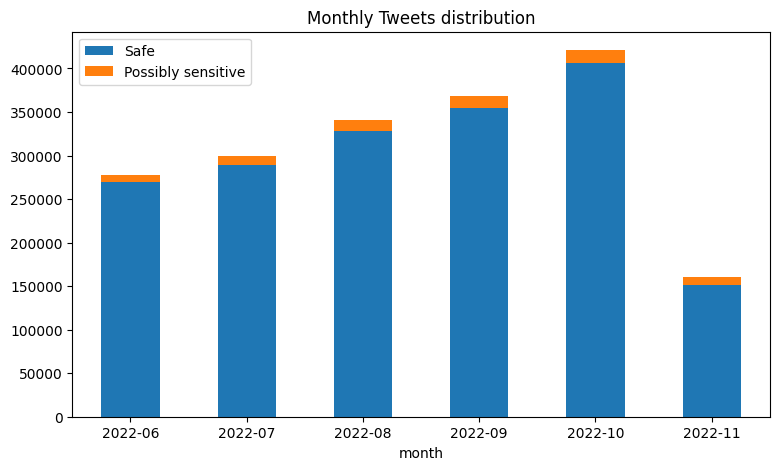

In [31]:
fig, ax = plt.subplots(1, figsize=(9, 5))

tweets_df_pivot = tweets_df[['month', 'possibly_sensitive', 'id']].pivot_table(index='month', columns=['possibly_sensitive'], aggfunc=len)
tweets_df_pivot.plot.bar(ax=ax, rot=0, stacked=True)

ax.set_title('Monthly Tweets distribution')
ax.legend(['Safe', 'Possibly sensitive'])
plt.show()

In [96]:
tweets_view[tweets_view.apply(lambda x: x['possibly_sensitive']==True and len(x['hashtags']) != 0, axis=1)][['hashtags', 'user_id']]

,hashtags,user_id
215,"[Cuckold, BBC, Hotwife, Cum]",911637468595867648
607,[HouseOfTheDragon],2203219998
611,[DWCS],2203219998
646,[dankmemes],2203219998
649,[dankmemes],2203219998
...,...,...
1849463,[onlyfans],4186179333
1849477,"[aussie, acent, speedo]",4186179333
1849517,"[bbc, porn, interracialporn, whitegirl, interr...",4186179333
1856995,"[Mykolaiv, Russian]",1439844719140409351


# Favorites

In [ ]:
favorites_df = tweets_view[['month', 'user_id', ]]

## month + favorite_count + user_id
  - What users have the most favorite count in total?
  - What users have the most favorite count on a monthly basis?
## month + favorite_count + hashtags
  - What hashtags have the most favorite count in total?
  - What hashtags have the most favorite count on a monthly basis?

# Hashtags

In [120]:
hashtags_df = tweets_view[['user_name', 'month', 'hashtags']].explode('hashtags').dropna()
month_htag_df = hashtags_df[['month', 'hashtags']].groupby(['month', 'hashtags']).size()

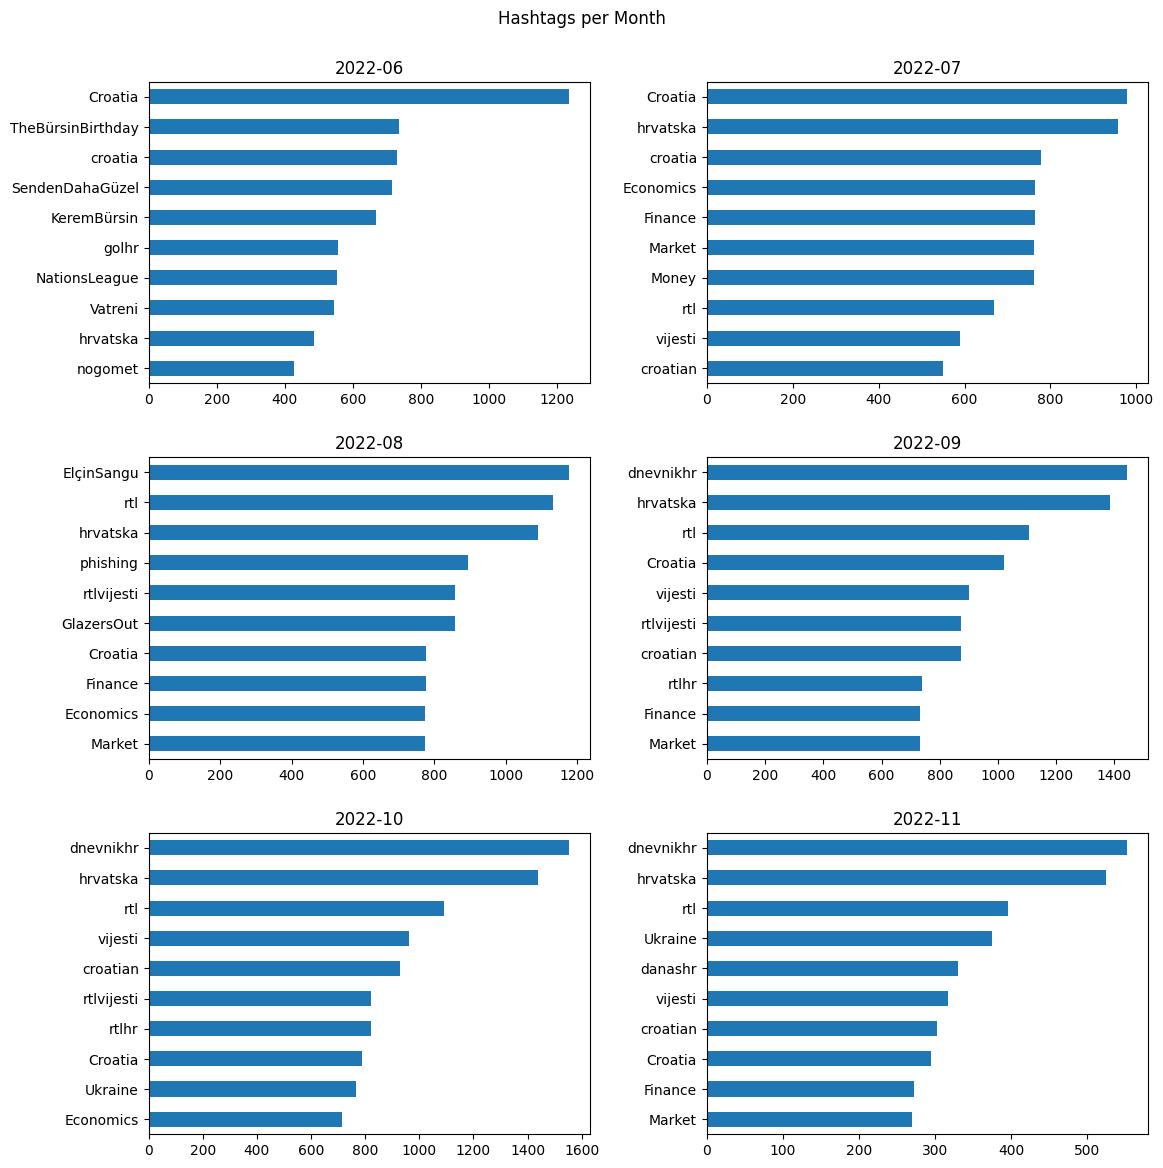

In [123]:
unique_months = tweets_view.month.unique()[::-1]
fig, axs = plt.subplots(nrows=int(len(unique_months)/2), ncols=2, figsize=(12, len(unique_months)*2))
plt.suptitle("Hashtags per Month")

j, k = 0, -1
for i, month in enumerate(unique_months):
    if i % 2 == 0: j = 0
    else: j = 1
    
    if j == 0: k += 1
    
    month_htag_df.loc[(month,)].sort_values().tail(10) \
      .plot.barh(ax=axs[k][j])
    axs[k][j].set_title(month)
    axs[k][j].set_ylabel(None)

fig.tight_layout(pad=2)
plt.show()

In [ ]:
# hashtags_df = tweets_view[['user_name', 'month', 'hashtags']].explode('hashtags').dropna()
month_users_htag_df = tweets_view[tweets_view['is_retweet'] == False][['month', 'user_name', 'hashtags']].groupby(['month', 'user_name']).sum()
month_htag_df = month_users_htag_df.groupby('month').sum()

In [63]:
hashtags_df = tweets_view[['user_name', 'hashtags']].copy()
hashtags_df['count_hashtags'] = hashtags_df['hashtags'].transform(lambda x: len(x))
hashtags_df = hashtags_df[hashtags_df['count_hashtags'] > 3]
hashtags_df.sample(20)#.sort_values('count_hashtags', ascending=False)

,user_name,hashtags,count_hashtags
893366,xjure,"[producthunt, design, uxdesign, uidesign, desi...",5
231040,lokalnahrvatska,"[Drniš, vijesti, hrvatska, croatian]",4
721181,TrninicIgor,"[BinanceGVR, GroveToken, GroveBusiness, GroveF...",4
628456,Pirgo691,"[GayFisting, GayFist, FistFuck, FFun]",4
722496,TrninicIgor,"[NEWS, Crypto, Solana, NFTs]",4
1430340,antonija_mioc,"[OktayÇubuk, NilKeser, AhNerede, ZehFer]",4
481339,RenaultHR,"[Renault, električan, ParisMotorShow, vanlife,...",6
571304,Crobot01,"[ProofOfMemes, Layer1, POMchain, ETH2, CultDao...",6
1782212,DijanaNovakK,"[BDCO, NFTs, NFTCommunity, nftarti̇st, nftarti...",10
1714792,AlenKarabegovic,"[Money, Finance, Economics, Market]",4


In [66]:
hashtags_df = hashtags_df[['user_name', 'hashtags']].sample(200).explode('hashtags').dropna()
hashtags_pivot = hashtags_df.pivot_table(index='user_name', columns=['hashtags'], aggfunc=len).fillna(0)
hashtags_pivot

hashtags,100DaysofCode,100xGems,2022BTSFESTA,3Dprint,Afghanistan,Airdrop,Amazon,Angular,AoD,August2022,...,平沢唯,마마무,마타하리,몬스타엑스,비투비의키스더라디오,육성재,전정국,정채연,정훈,지민슬라임탱탱_피부부러워
user_name,,,,,,,,,,,,,,,,,,,,,
0viking0VR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AlenKarabegovic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AmadriaPark,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AnimalsWBorders,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BalanceFM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
unikatikeramika,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
unisi_si,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
xjoint_,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## month + hashtags
  - What are the most frequently used hashtags on a monthly basis?
## hashtags + user_id
  - What hashtags are linked to a user on average in total?
  - What hashtags are linked to a user on average on a monthly basis?

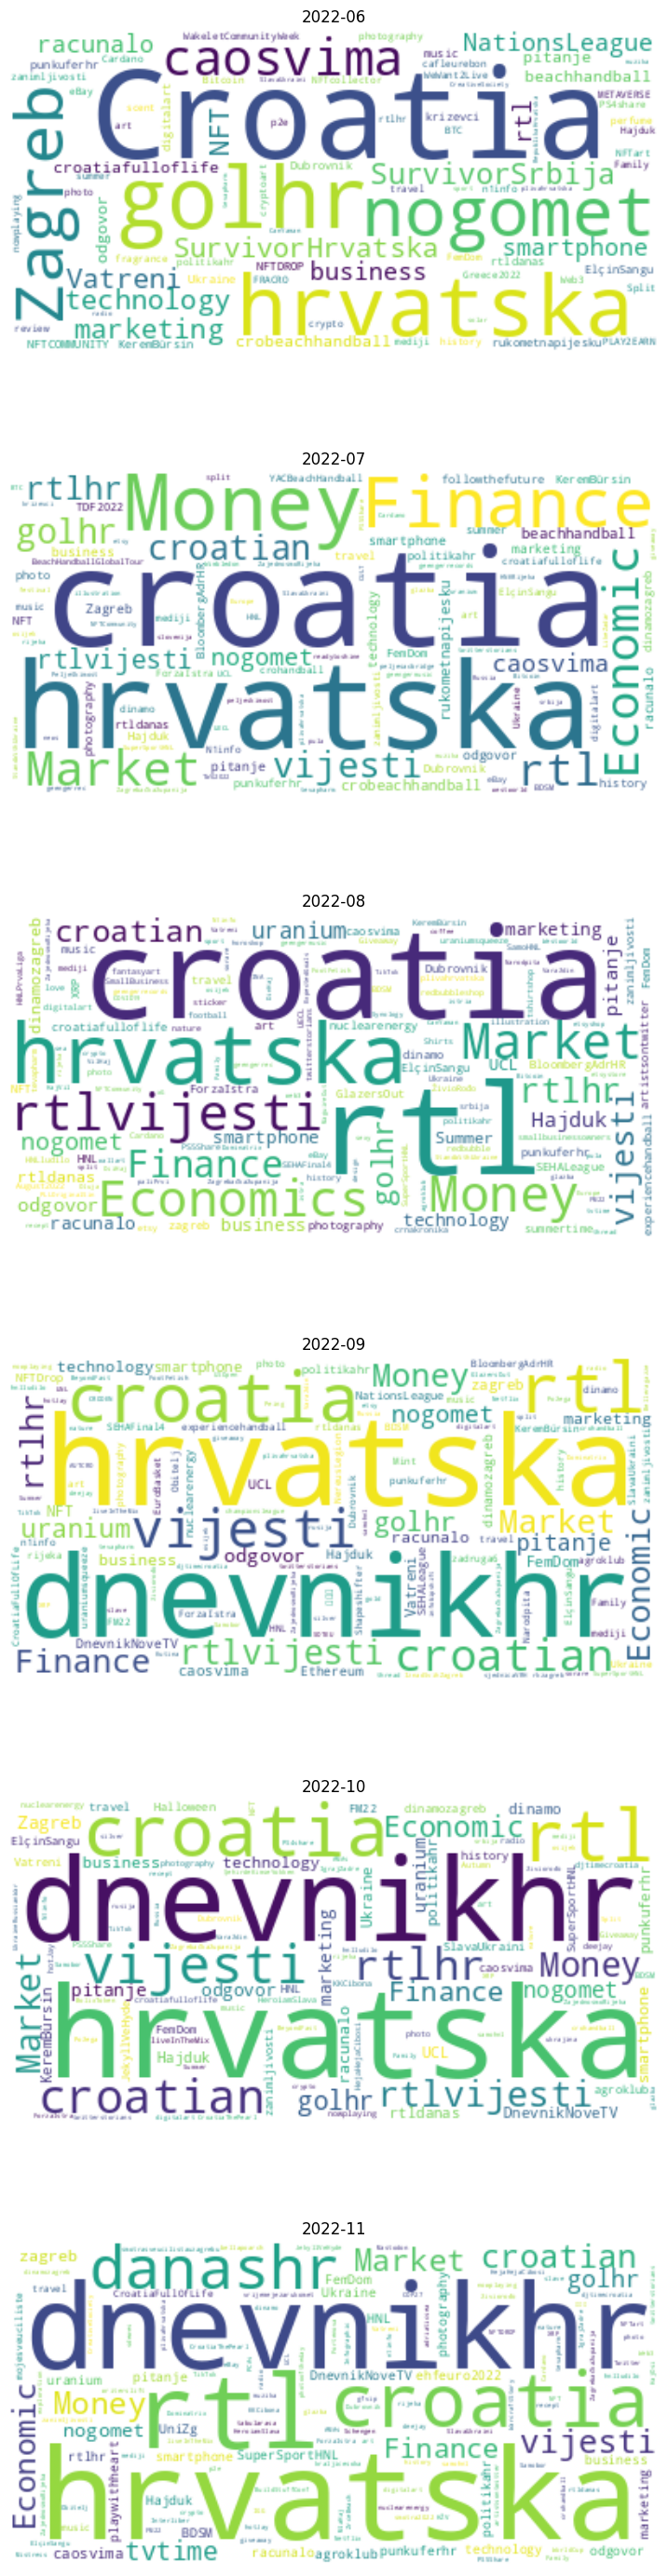

In [45]:
from wordcloud import WordCloud

unique_months = month_htag_df.index
fig, axs = plt.subplots(len(unique_months), figsize=(9, len(unique_months)*6))

for i, month in enumerate(unique_months):
    string = " ".join(month_htag_df.loc[month, 'hashtags'])
    wordcloud = WordCloud(collocations=False, background_color='white').generate(string)
    axs[i].imshow(wordcloud, interpolation='bilinear')
    axs[i].set_title(month)
    axs[i].axis('off')
plt.show()

In [ ]:
unique_months = tweets_view.month.unique()
fig, axs = plt.subplots(len(unique_months), figsize=(9, len(unique_months) * 5))

plt.title('Tweet Distribution per Month by User')

top_tweeters = tweets_view[tweets_view['is_retweet'] == False][[
    'month', 'user_name'
]].groupby(['month', 'user_name']).size()
max_tweets = top_tweeters.max()

for i, month in enumerate(unique_months[::-1]):
    top_tweeters.loc[(month, )].sort_values().tail(10).plot.barh(ax=axs[i])
    axs[i].set_title(month)
    axs[i].set_xlim(xmin=0, xmax=max_tweets+50)

fig.tight_layout(pad=2)
plt.show()


In [ ]:
fig, ax = plt.subplots(1, figsize=None)

htag_count = tweets_view['hashtags'].explode().dropna().value_counts()
htag_count.head(25).iloc[::-1].plot.barh(ax=ax)

ax.set_title('Most tweeted Hashtags')
plt.show()

In [ ]:
fig, ax = plt.subplots(1, figsize=(9, 7))

ument_count = tweets_view[['user_id', 'user_mentions']].explode('user_mentions').dropna()
ument_count = ument_count.merge(users_df[['user_id', 'screen_name']], how='inner', on='user_id')
ument_count = ument_count.merge(users_df[['user_id', 'screen_name']], how='left', left_on='user_mentions', right_on='user_id', suffixes=['_source', '_target'])
ument_count = ument_count.groupby(['screen_name_source', 'screen_name_target']).size().sort_values(ascending=False)
ument_count.head(25).iloc[::-1].plot.barh(ax=ax)

ax.set_title('Most mentioned Users')
ax.set_ylabel('Source User to Mentioned User')
ax.set_yticklabels(["{} -- {}".format(src, tgt) for src, tgt in ument_count.head(25).iloc[::-1].index])
plt.show()

In [ ]:
retweet_view = tweets_df[[
    'id', 
    'user_id', 
    'created_at', 
    'full_text', 
    'retweet_from_user_id', 
    'retweet_from_tweet_id', 
    'retweet_created_at'
]].rename(columns={
    'id':                   'rt_tweet_id', 
    'user_id':              'rt_user_id', 
    'created_at':           'rt_created_at', 
    'full_text':            'full_text', 
    'retweet_created_at':   'og_created_at',
    'retweet_from_user_id': 'og_user_id', 
    'retweet_from_tweet_id': 'og_tweet_id'
}).merge()

In [ ]:
tweets_df.groupby('user_id').size()
# .agg(total_tweets=('user_id', 'size')).join(user_df.set_index('user_id'), how='inner')